In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()
    

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.insert(0, "../src")

import numpy
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt
pyplot.style.use("tlrh")

from amuse import datamodel
from amuse.units import units
from amuse.units import constants
from amuse.units import nbody_system
from amuse.ic.kingmodel import new_king_model
from amuse.ic.plummer import new_plummer_sphere
from amuse.support.console import set_printing_strategy
set_printing_strategy("custom", preferred_units=[
    units.MSun, units.parsec, units.Myr, units.kms],
    precision=2, prefix="", separator=" ", suffix="")

numpy.random.seed(1337)

from plummer import *
from kingmodel import *
from datamodel import get_radial_profiles
from datamodel import plot_radial_profiles
from datamodel import scatter_particles_xyz
from datamodel import print_particleset_info

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

## Generate Plummer and King models

In [4]:
Nstars = 50000
Mtotal = 30000 | units.MSun
Rcluster = 1 | units.parsec
convert_nbody = nbody_system.nbody_to_si(Mtotal, Rcluster)
plummer = new_plummer_sphere(Nstars, convert_nbody)
king5 = new_king_model(Nstars, 5, convert_nbody)
king7 = new_king_model(Nstars, 7, convert_nbody)

# We can work on the new plummer particle set, but we want to keep this set
# unchanged for now. So, we copy all data to a working set.
p = plummer.copy()
k5 = king5.copy()
k7 = king7.copy()

In [5]:
print("converter.length = {0} parsec\nconverter.mass = {1} MSun"
      "\nconverter.time = {2} yr\n".format(
    (convert_nbody.units[0][1]).value_in(units.parsec),
    (convert_nbody.units[1][1]).value_in(units.MSun),
    (convert_nbody.units[2][1]).value_in(units.yr)
))

print_particleset_info(p, convert_nbody, "Plummer sphere")
print_particleset_info(k5, convert_nbody, "King model, W0=5")
print_particleset_info(k7, convert_nbody, "King model, W0=7")

converter.length = 1.0000000000000004 parsec
converter.mass = 30000.00000000006 MSun
converter.time = 86071.5513024381 yr

Sampled 50000 stars in a Plummer sphere
  Mtotal (requested): 30000.00000000006, Mtot (sampled): 3.0e+04 MSun
  Ekin (sampled): 1.92e+42 J (1.92e+49 erg) [9.64e+05 Msun/kms**2]
  Epot (sampled): -3.85e+42 J (-3.85e+49 erg) [-1.93e+06 Msun/kms**2]
  Virial ratio (-2*Ekin / Epot): 0.9964476191555364
  CoM (sampled): [7.5e-19, -4.8e-18, 1.0e-17] parsec
  pos: [-0.0022, -5.9e-05, 0.010] parsec
  r0: 3.98e-01 parsec,  rho0: 1.36e+05 MSun/parsec**3

Sampled 50000 stars in a King model, W0=5
  Mtotal (requested): 30000.00000000006, Mtot (sampled): 3.0e+04 MSun
  Ekin (sampled): 1.93e+42 J (1.93e+49 erg) [9.70e+05 Msun/kms**2]
  Epot (sampled): -3.85e+42 J (-3.85e+49 erg) [-1.94e+06 Msun/kms**2]
  Virial ratio (-2*Ekin / Epot): 1.0011437158433936
  CoM (sampled): [8.8e-18, -1.6e-17, 7.2e-18] parsec
  pos: [0.0032, -0.0023, -0.0016] parsec
  r0: 4.04e-01 parsec,  rho0: 2.17

## Show radial profiles (Count, Mass, Density) 

### Plummer Sphere

Plotting draw_max = 1337 particles
Total radius: 22.55 parsec
Virial radius: 1.00 parsec


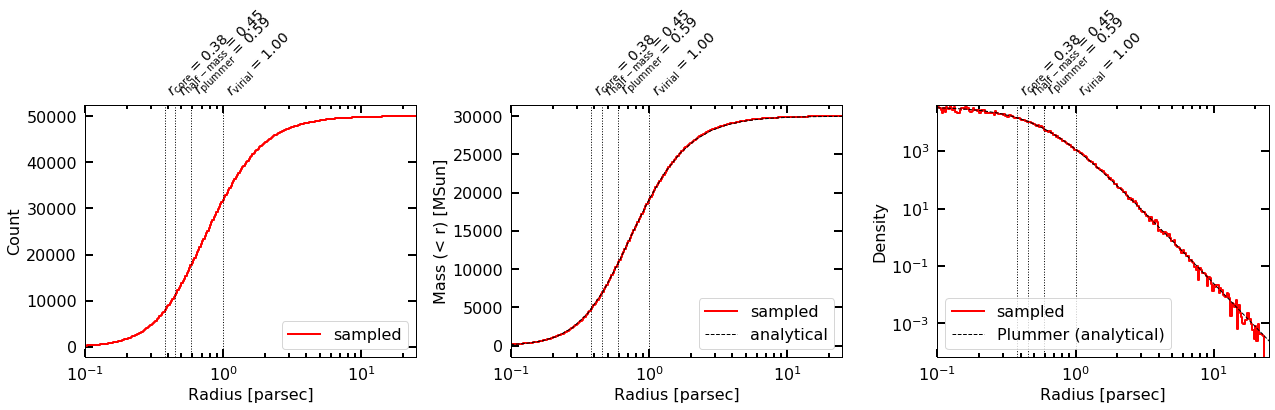

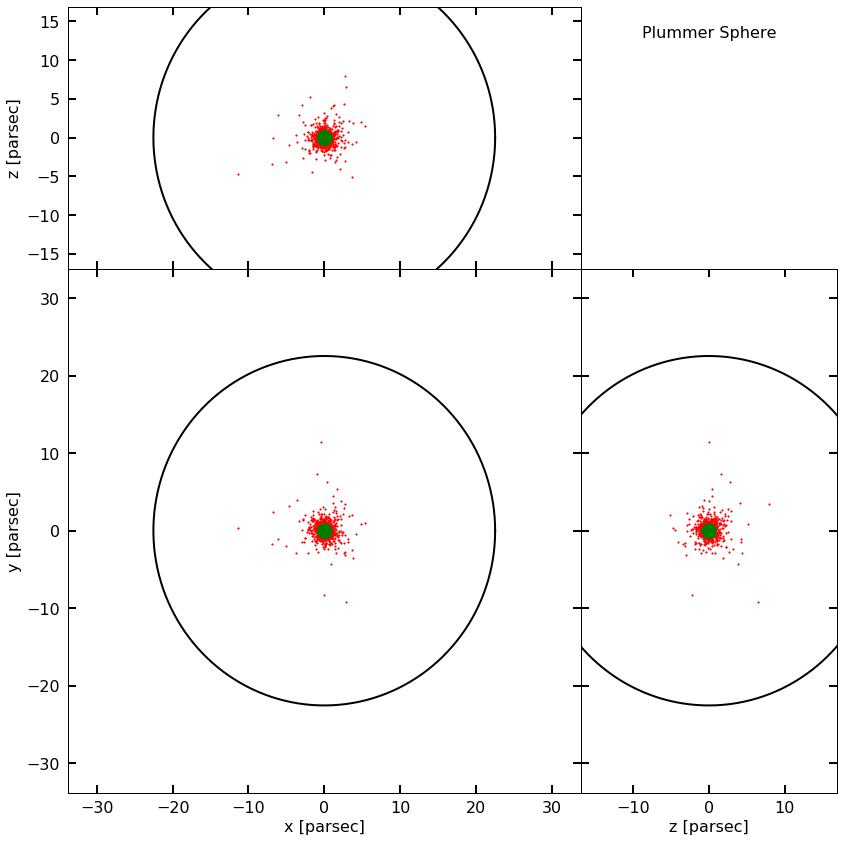

In [6]:
a = 3*numpy.pi/16 | units.parsec  # b/c AMUSE default

rmin = 0.1  # parsec
rmax = 25   # parsec
radii, N_in_shell, M_below_r, rho_of_r = \
    get_radial_profiles(p, rmin=rmin, rmax=rmax, N=256)

fig, (ax1, ax2, ax3) = plot_radial_profiles(
    p, radii, N_in_shell, M_below_r, rho_of_r, rmin, rmax)

r_ana = numpy.logspace(-3, 4, 64) | units.parsec
add_plummer_mass_profile_to_ax(ax2, p, a, r_ana)
add_plummer_density_profile_to_ax(ax3, p, a, r_ana)
for ax in [ax1, ax2, ax3]:
    add_plummer_radii_to_ax(ax, p, a)
    ax.legend()
fig.tight_layout()


fig = scatter_particles_xyz(p, labels=["Plummer Sphere"])
fig.show()

# Use AMUSE to get radial density and mass profile of King (1966) model

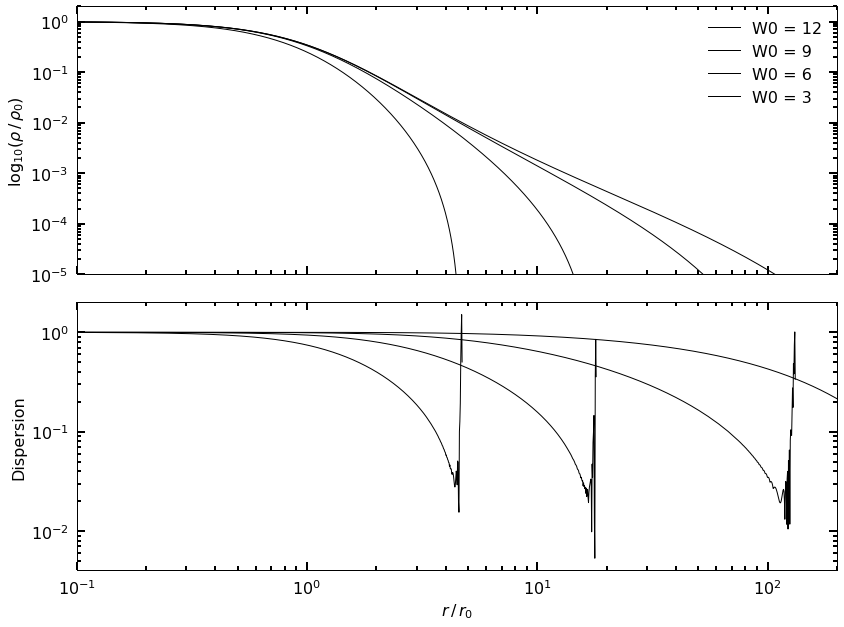

In [7]:
from amuse.ic.kingmodel import MakeKingModel
# AMUSE's King (1966) model implementation, but w/o particles.
# Just want AMUSE to solve Poisson equation for King distribution function to give me
# rho(r), and MakeKingModel.poisson does just that and parks output in self.rr and self.d.
# The mass profile M(<r) is self.zm, the scaled potential is self.psi

fig, (ax1, ax2) = pyplot.subplots(2, 1, figsize=(12, 9), sharex=True)

# W0 = -phi_0 / sig^2
# rc^2 =  9 sig^2 / (4 pi G rho0)
zero_particles = 0
for W0 in [12, 9, 6, 3]:
    king = MakeKingModel(zero_particles, W0)
    king.verbose = True
    nprof, v20 = king.poisson()  # nprof is number of points generated, v20 is central 3D velocity dispersion

    ax1.plot(king.rr, king.d, c="k", label="W0 = {0}".format(W0))
    ax2.plot(king.rr, king.v2, c="k", label="W0 = {0}".format(W0))

ax1.set_ylabel("$\log_{10}(\\rho \, / \, \\rho_0)$")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim(0.1, 200)
ax1.set_ylim(1e-5, 2)

ax2.set_ylabel("Dispersion")
ax2.set_xlabel("$r \, / \, r_0$")
ax2.set_yscale("log")

ax1.legend(fontsize=16, frameon=False)
pyplot.tight_layout()
pyplot.show()

### King Model, W0 = 5

Plotting draw_max = 1337 particles
Total radius: 4.27 parsec
Virial radius: 1.00 parsec


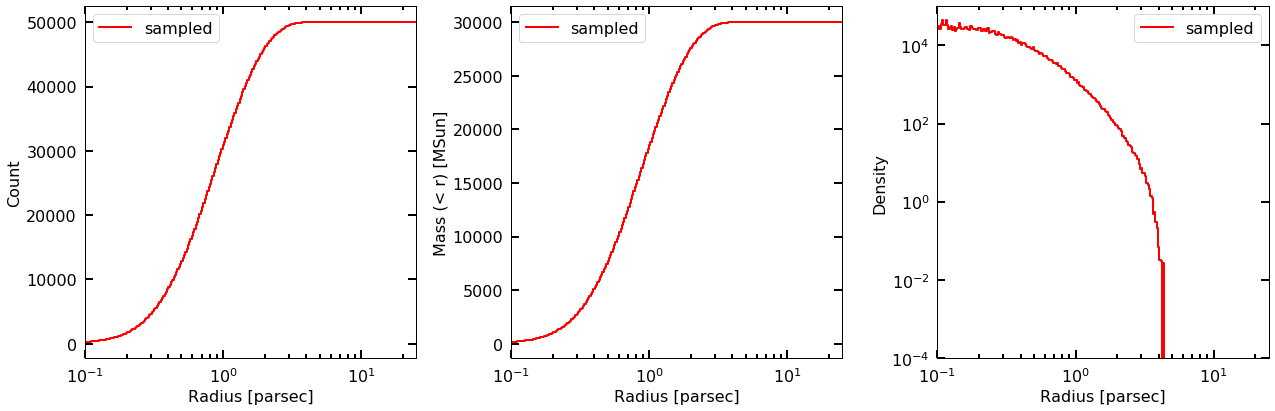

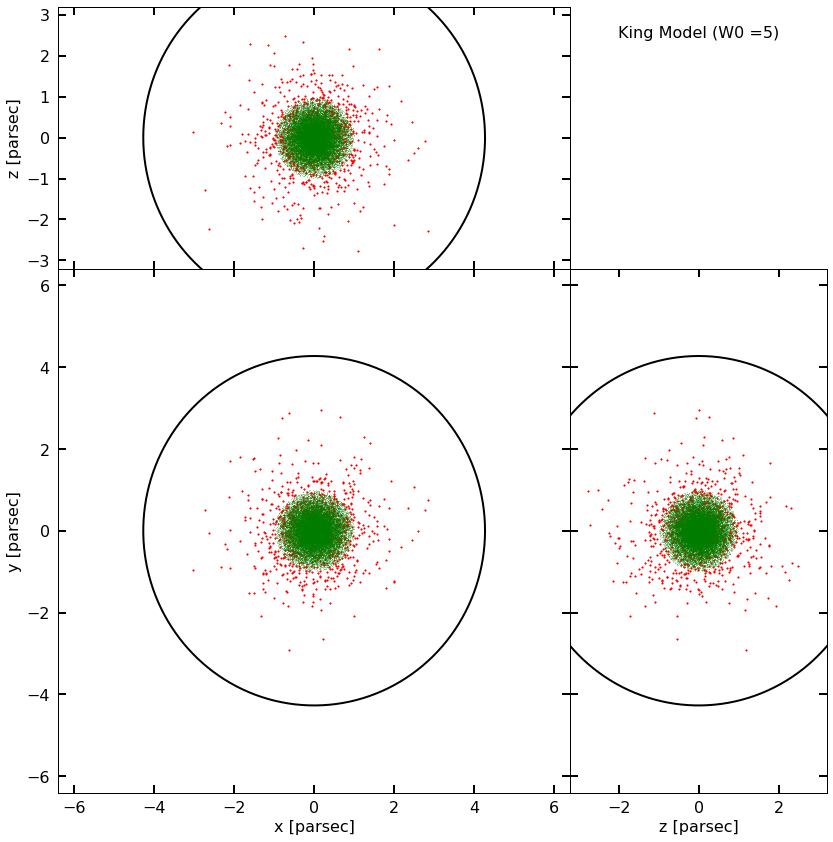

In [8]:
radii, N_in_shell, M_below_r, rho_of_r = \
    get_radial_profiles(k5, rmin=rmin, rmax=rmax, N=256)

fig, (ax1, ax2, ax3) = plot_radial_profiles(
    k5, radii, N_in_shell, M_below_r, rho_of_r, rmin, rmax)

# r_ana = numpy.logspace(-3, 4, 64) | units.parsec
# add_king_mass_profile_to_ax(ax2, p, a, r_ana)
# add_king_density_profile_to_ax(ax3, p, a, r_ana)
# for ax in [ax1, ax2, ax3]:
#     add_king_radii_to_ax(ax, p, a)
#     ax.legend()
ax3.set_ylim(1e-4, 1e5)
fig.tight_layout()


fig = scatter_particles_xyz(k5, labels=["King Model (W0 =5)"])
fig.show()

Plotting draw_max = 1337 particles
Total radius: 6.60 parsec
Virial radius: 1.01 parsec


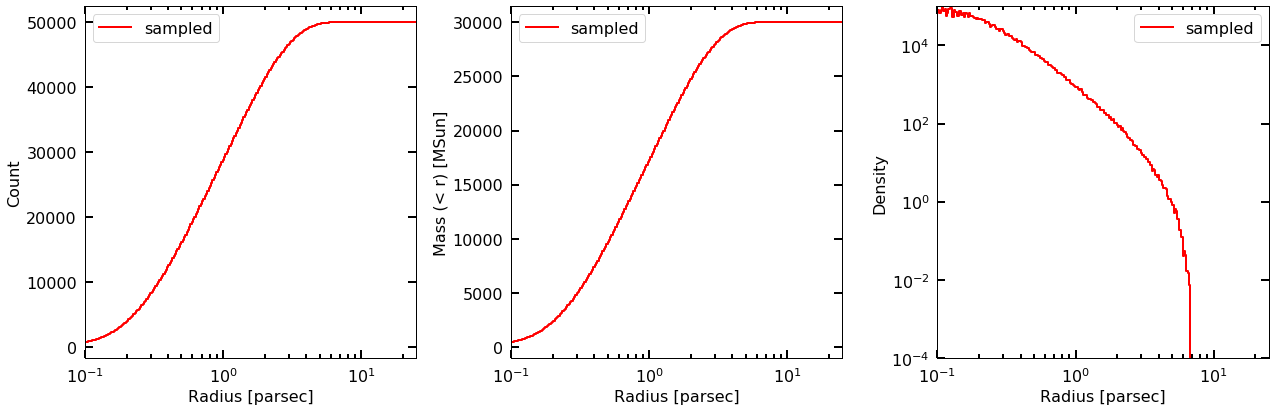

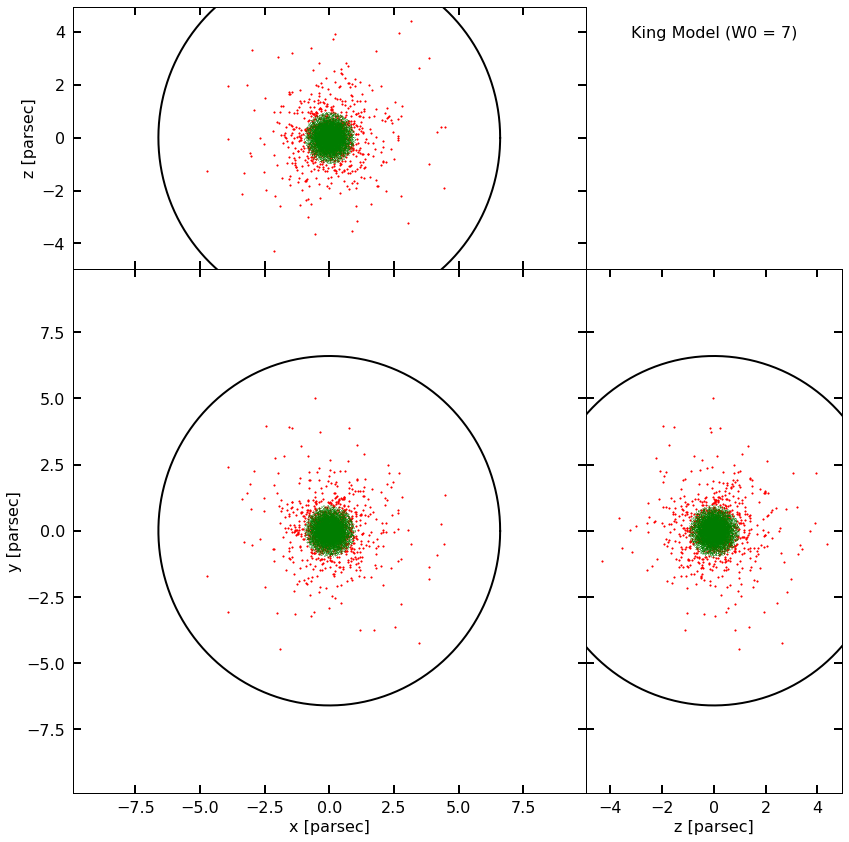

In [9]:
radii, N_in_shell, M_below_r, rho_of_r = \
    get_radial_profiles(k7, rmin=rmin, rmax=rmax, N=256)

fig, (ax1, ax2, ax3) = plot_radial_profiles(
    k5, radii, N_in_shell, M_below_r, rho_of_r, rmin, rmax)

# r_ana = numpy.logspace(-3, 4, 64) | units.parsec
# add_king_mass_profile_to_ax(ax2, p, a, r_ana)
# add_king_density_profile_to_ax(ax3, p, a, r_ana)
# for ax in [ax1, ax2, ax3]:
#     add_king_radii_to_ax(ax, p, a)
#     ax.legend()
ax3.set_ylim(1e-4, 1e5)
fig.tight_layout()


fig = scatter_particles_xyz(k7, labels=["King Model (W0 = 7)"])
fig.show()

## TODO: find all bound particles

In [ ]:
plum = new_plummer_sphere(100)
print(len(plum.bound_subset(G=nbody_system.G)))

plum[0].velocity *= 100
plum[0].position *= 100
print(len(plum.bound_subset(G=nbody_system.G)))

print(constants.G.value_in(units.m**3 * units.kg**-1 * units.s**-2))
# stars.bound_subset(G=nbody_system.G)